In [1]:
import pandas as pd
from pandas import read_json, DataFrame
import json
import numpy as np
from copy import deepcopy

In [2]:
df = read_json("./matches2.json")
df = df[["ID", "sclassName", "hometeam", "guestteam", "homescore", "guestscore", "timeStamp", "records"]]

In [3]:
# ['时间', '比分', '主', '盘', '客', '变化', '状']
def filterNullRecords(data):
    # print(data["headers"])
    # print(data["records"])
    return bool(data["records"])


cond2 = df["records"].map(filterNullRecords)
df = df[cond2]

In [4]:
# 过滤没有初盘终盘的比赛
def convertRecords(records: dict):
    records = deepcopy(records["records"])
    records.reverse()
    pans = []

    for time, score, zhu, pan, ke, change, state in records:
        if not time:
            if len(pans) < 3:
                pans.append(pan)
            else:
                pans[-1] = pan
    if len(pans) < 1 or len(records) < 10 or not records[-1][0]:
        return False
    else:
        return True


cond3 = df["records"].map(convertRecords)
df = df[cond3]

# 过滤没有最终比分的比赛
df = df.query("homescore != '' or guestscore != ''")

In [5]:
from copy import deepcopy


# 获取初盘和终盘
def getPan(records: dict):
    records = deepcopy(records["records"])
    records.reverse()
    pans = []
    for time, score, zhu, pan, ke, change, state in records:
        if not time:
            if len(pans) < 3:
                pans.append(pan)
            else:
                pans[-1] = pan
    return [pans[0], pans[-1]]


df["pans"] = df["records"].map(getPan).copy()
df["chupan"] = df["pans"].map(lambda i: float(i[0]))
df["zhongpan"] = df["pans"].map(lambda i: float(i[1]))

In [6]:
# 对数据类型进行转换
def getName(arr):
    return arr[0]


df["guestteam"] = df["guestteam"].map(getName).copy()
df["hometeam"] = df["hometeam"].map(getName).copy()
df["sclassName"] = df["sclassName"].map(getName).copy()
df["homescore"] = df["homescore"].map(lambda s: int(s)).copy()
df["guestscore"] = df["guestscore"].map(lambda s: int(s)).copy()
df["finalScore"] = df["homescore"] - df["guestscore"]

In [7]:
# 过滤实时历史记录中不需要统计的列
def filterRecords(records):
    records = deepcopy(records["records"])
    records.reverse()
    filtered = []
    for time, score, zhu, pan, ke, change, state in records:
        if time and score and pan and "封" not in pan and "加时" not in time and "中场" not in time:
            filtered.append([time, score, pan])
    return filtered


df["records"] = df["records"].map(filterRecords)

In [8]:
df

,ID,sclassName,hometeam,guestteam,homescore,guestscore,timeStamp,records,pans,chupan,zhongpan,finalScore
0,485395,NBA,费城76人[东5],底特律活塞[东15],147,116,2023-01-09 16:00:00,"[[第一节 11:35, 2-0, 14.5], [第一节 11:29, 2-0, 14.5...","[11.5, 14.5]",11.5,14.5,31
1,485393,NBA,迈阿密热火[东8],俄克拉荷马城雷霆[西13],112,111,2023-01-09 16:00:00,"[[第一节 07:57, 13-8, 2.5], [第一节 07:24, 16-10, 3....","[4.5, 1.5]",4.5,1.5,1
2,485394,NBA,多伦多猛龙[东11],夏洛特黄蜂[东14],132,120,2023-01-09 16:00:00,"[[第一节 11:42, 0-0, 7.5], [第一节 11:20, 0-0, 7.5],...","[7.5, 7.5]",7.5,7.5,12
3,485396,NBA,犹他爵士[西11],克里夫兰骑士[东4],116,114,2023-01-09 16:00:00,"[[第一节 10:37, 2-3, -2.5], [第一节 10:13, 4-3, -2.5...","[-3.5, -2.5]",-3.5,-2.5,2
4,485397,NBA,波特兰开拓者[西10],奥兰多魔术[东13],106,109,2023-01-09 16:00:00,"[[第一节 11:30, 0-0, 8.5], [第一节 11:23, 0-2, 8.5],...","[6.5, 8.5]",6.5,8.5,-3
...,...,...,...,...,...,...,...,...,...,...,...,...
50171,435963,欧女联,威尼斯雷耶女篮[意女篮2],里加女篮,54,62,2022-01-11 16:00:00,"[[第四节 06:41, 51-54, -1.5], [第四节 06:41, 51-54, ...","[9, 9]",9.0,9.0,-8
50172,439771,巴西甲,保利斯坦奴[8],南卡西亚斯[7],89,83,2022-01-11 16:00:00,"[[第一节 08:30, 2-2, 19.5], [第一节 08:30, 2-2, 19.5...","[19.5, 19]",19.5,19.0,6
50173,439772,巴西甲,圣保罗[4],帕图[11],86,77,2022-01-11 16:00:00,"[[第一节 08:23, 2-3, 2.5], [第一节 07:59, 2-3, 1.5],...","[7, 1.5]",7.0,1.5,9
50174,454017,巴西甲,哥连泰斯[16],哥连泰斯联[15],74,63,2022-01-11 16:00:00,"[[第一节 08:38, 3-0, 10], [第一节 08:38, 3-0, 10], [...","[12, 9]",12.0,9.0,11


# 数据分析阶段

In [9]:
# 按联赛进行统计
df.groupby("sclassName").size()

sclassName
BIBL         1
BNXT       156
Big V       40
Big V女篮     37
CBA        406
          ... 
韩篮甲        263
韩篮甲季后       18
马里甲          4
黎巴女联         1
黎巴联         13
Length: 323, dtype: int64

In [10]:
df2 = df.copy()
df2

,ID,sclassName,hometeam,guestteam,homescore,guestscore,timeStamp,records,pans,chupan,zhongpan,finalScore
0,485395,NBA,费城76人[东5],底特律活塞[东15],147,116,2023-01-09 16:00:00,"[[第一节 11:35, 2-0, 14.5], [第一节 11:29, 2-0, 14.5...","[11.5, 14.5]",11.5,14.5,31
1,485393,NBA,迈阿密热火[东8],俄克拉荷马城雷霆[西13],112,111,2023-01-09 16:00:00,"[[第一节 07:57, 13-8, 2.5], [第一节 07:24, 16-10, 3....","[4.5, 1.5]",4.5,1.5,1
2,485394,NBA,多伦多猛龙[东11],夏洛特黄蜂[东14],132,120,2023-01-09 16:00:00,"[[第一节 11:42, 0-0, 7.5], [第一节 11:20, 0-0, 7.5],...","[7.5, 7.5]",7.5,7.5,12
3,485396,NBA,犹他爵士[西11],克里夫兰骑士[东4],116,114,2023-01-09 16:00:00,"[[第一节 10:37, 2-3, -2.5], [第一节 10:13, 4-3, -2.5...","[-3.5, -2.5]",-3.5,-2.5,2
4,485397,NBA,波特兰开拓者[西10],奥兰多魔术[东13],106,109,2023-01-09 16:00:00,"[[第一节 11:30, 0-0, 8.5], [第一节 11:23, 0-2, 8.5],...","[6.5, 8.5]",6.5,8.5,-3
...,...,...,...,...,...,...,...,...,...,...,...,...
50171,435963,欧女联,威尼斯雷耶女篮[意女篮2],里加女篮,54,62,2022-01-11 16:00:00,"[[第四节 06:41, 51-54, -1.5], [第四节 06:41, 51-54, ...","[9, 9]",9.0,9.0,-8
50172,439771,巴西甲,保利斯坦奴[8],南卡西亚斯[7],89,83,2022-01-11 16:00:00,"[[第一节 08:30, 2-2, 19.5], [第一节 08:30, 2-2, 19.5...","[19.5, 19]",19.5,19.0,6
50173,439772,巴西甲,圣保罗[4],帕图[11],86,77,2022-01-11 16:00:00,"[[第一节 08:23, 2-3, 2.5], [第一节 07:59, 2-3, 1.5],...","[7, 1.5]",7.0,1.5,9
50174,454017,巴西甲,哥连泰斯[16],哥连泰斯联[15],74,63,2022-01-11 16:00:00,"[[第一节 08:38, 3-0, 10], [第一节 08:38, 3-0, 10], [...","[12, 9]",12.0,9.0,11


In [11]:
sclasss = df2.groupby("sclassName").groups

In [12]:
sclasss['BIBL']

Int64Index([34639], dtype='int64')

In [13]:
temp = df2.groupby("sclassName")

In [14]:
temp["ID"].count().to_json()

'{"BIBL":1,"BNXT":156,"Big V":40,"Big V\\u5973\\u7bee":37,"CBA":406,"CBA\\u5b63\\u524d":1,"CBA\\u5b63\\u540e":27,"CBI":1,"CIT":2,"EBBL\\u676f":13,"Euro":296,"LNB U21":7,"NBA":1227,"NBA\\u5b63\\u524d":70,"NBA\\u5b63\\u540e":93,"NBA\\u660e\\u661f\\u8d5b":1,"NBL(A)":216,"NBL(A)\\u5b63\\u524d":14,"NBL(A)\\u5b63\\u540e":8,"NBL(U)":13,"NBL1(\\u4e1c)":80,"NBL1(\\u4e1c)\\u5b63\\u540e":5,"NBL1(\\u4e2d)":30,"NBL1(\\u4e2d)\\u5b63\\u540e":6,"NBL1(\\u5317)":92,"NBL1(\\u5317)\\u5b63\\u540e":8,"NBL1(\\u5357)":180,"NBL1(\\u5357)\\u5b63\\u540e":9,"NBL1(\\u897f)":122,"NBL1(\\u897f)\\u5b63\\u540e":9,"NBL1\\u5b63\\u540e\\u8d5b":9,"NBL\\u95ea\\u7535":1,"NCAA":3293,"NIT":3,"P\\u8054\\u8d5b":19,"T1\\u8054\\u8d5b":7,"VTB\\u676f":196,"VTB\\u8d85\\u676f":5,"VTB\\u9752\\u8054":2,"WNBA":216,"WNBA\\u5b63\\u524d":4,"WNBA\\u5b63\\u540e":23,"WNBA\\u660e\\u661f\\u8d5b":1,"WNBL(U)":7,"WNBL1(\\u4e1c)":72,"WNBL1(\\u4e1c)\\u5b63\\u540e":5,"WNBL1(\\u4e2d)":35,"WNBL1(\\u4e2d)\\u5b63\\u540e":5,"WNBL1(\\u5317)":112,"WNBL1(\\u

In [15]:
cba_index = sclasss["CBA"]
cba = df2.loc[cba_index]
cba

,ID,sclassName,hometeam,guestteam,homescore,guestscore,timeStamp,records,pans,chupan,zhongpan,finalScore
7,506481,CBA,辽宁本钢[2],北京首钢[4],82,74,2023-01-09 16:00:00,"[[第一节 11:42, 0-0, 6.5], [第一节 11:42, 2-0, 6.5],...","[3.5, 6.5]",3.5,6.5,8
8,506482,CBA,四川金荣实业[17],南京同曦宙光[9],84,107,2023-01-09 16:00:00,"[[第一节 11:08, 0-2, -23.5], [第一节 10:38, 2-2, -22...","[-10.5, -22.5]",-10.5,-22.5,-23
9,506483,CBA,山西汾酒股份[12],青岛国信水产[14],114,99,2023-01-09 16:00:00,"[[第一节 10:42, 0-0, 4.5], [第一节 10:01, 0-2, 3.5],...","[3.5, 4.5]",3.5,4.5,15
10,506484,CBA,新疆伊力王酒[9],深圳马可波罗[6],92,91,2023-01-09 16:00:00,"[[第一节 09:45, 4-0, 2.5], [第一节 09:16, 4-0, 3.5],...","[3.5, 2.5]",3.5,2.5,1
11,506485,CBA,广州龙狮[16],宁波町渥[20],105,84,2023-01-09 16:00:00,"[[第一节 11:46, 0-0, 15.5], [第一节 11:37, 2-0, 16.5...","[15.5, 15.5]",15.5,15.5,21
...,...,...,...,...,...,...,...,...,...,...,...,...
49941,449976,CBA,四川金荣实业[14],广州龙狮[7],71,92,2022-01-12 16:00:00,"[[第一节 10:02, 2-5, -8.5], [第一节 09:57, 2-5, -7.5...","[-5.5, -5.5]",-5.5,-5.5,-21
49942,449977,CBA,南京同曦宙光[20],北京首钢[9],77,114,2022-01-12 16:00:00,"[[第一节 10:59, 2-3, -27.5], [第一节 09:48, 2-5, -28...","[-24.5, -27.5]",-24.5,-27.5,-37
49943,449978,CBA,浙江稠州金租[4],新疆伊力王酒[13],98,91,2022-01-12 16:00:00,"[[第一节 11:35, 0-0, 8.5], [第一节 11:21, 0-0, 8.5],...","[8.5, 8.5]",8.5,8.5,7
49944,449979,CBA,天津先行者[16],山西汾酒股份[6],113,109,2022-01-12 16:00:00,"[[第一节 11:06, 0-2, -13.5], [第一节 10:34, 0-4, -14...","[-11.5, -12.5]",-11.5,-12.5,4


In [21]:
### START 判断是初盘还是终盘，得到panName IN[df] OUT[df,panName]
def countPan(df):
    cond = (df["chupan"] - df["finalScore"]).abs() > (df["zhongpan"] - df["finalScore"]).abs()
    cond2 = (df["chupan"] - df["finalScore"]).abs() < (df["zhongpan"] - df["finalScore"]).abs()
    zhongCount = len(df[cond])
    chuCount = len(df[cond2])
    res = "zhongpan" if zhongCount > chuCount else "chupan"
    df[f"res_{res}"] = df[res]
    return res


panName = countPan(cba)
### END

In [19]:
panName

'zhongpan'

In [20]:
df

,ID,sclassName,hometeam,guestteam,homescore,guestscore,timeStamp,records,pans,chupan,zhongpan,finalScore,res_zhongpan
0,485395,NBA,费城76人[东5],底特律活塞[东15],147,116,2023-01-09 16:00:00,"[[第一节 11:35, 2-0, 14.5], [第一节 11:29, 2-0, 14.5...","[11.5, 14.5]",11.5,14.5,31,14.5
1,485393,NBA,迈阿密热火[东8],俄克拉荷马城雷霆[西13],112,111,2023-01-09 16:00:00,"[[第一节 07:57, 13-8, 2.5], [第一节 07:24, 16-10, 3....","[4.5, 1.5]",4.5,1.5,1,1.5
2,485394,NBA,多伦多猛龙[东11],夏洛特黄蜂[东14],132,120,2023-01-09 16:00:00,"[[第一节 11:42, 0-0, 7.5], [第一节 11:20, 0-0, 7.5],...","[7.5, 7.5]",7.5,7.5,12,7.5
3,485396,NBA,犹他爵士[西11],克里夫兰骑士[东4],116,114,2023-01-09 16:00:00,"[[第一节 10:37, 2-3, -2.5], [第一节 10:13, 4-3, -2.5...","[-3.5, -2.5]",-3.5,-2.5,2,-2.5
4,485397,NBA,波特兰开拓者[西10],奥兰多魔术[东13],106,109,2023-01-09 16:00:00,"[[第一节 11:30, 0-0, 8.5], [第一节 11:23, 0-2, 8.5],...","[6.5, 8.5]",6.5,8.5,-3,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,435963,欧女联,威尼斯雷耶女篮[意女篮2],里加女篮,54,62,2022-01-11 16:00:00,"[[第四节 06:41, 51-54, -1.5], [第四节 06:41, 51-54, ...","[9, 9]",9.0,9.0,-8,9.0
50172,439771,巴西甲,保利斯坦奴[8],南卡西亚斯[7],89,83,2022-01-11 16:00:00,"[[第一节 08:30, 2-2, 19.5], [第一节 08:30, 2-2, 19.5...","[19.5, 19]",19.5,19.0,6,19.0
50173,439772,巴西甲,圣保罗[4],帕图[11],86,77,2022-01-11 16:00:00,"[[第一节 08:23, 2-3, 2.5], [第一节 07:59, 2-3, 1.5],...","[7, 1.5]",7.0,1.5,9,1.5
50174,454017,巴西甲,哥连泰斯[16],哥连泰斯联[15],74,63,2022-01-11 16:00:00,"[[第一节 08:38, 3-0, 10], [第一节 08:38, 3-0, 10], [...","[12, 9]",12.0,9.0,11,9.0


In [22]:
def calc(df, thresholdRange=(6, 20), level=0, q=5, calc_type="增量"):
    """
    根据监控阈值计算有效性
    :param df: 输入的单一联赛
    :param thresholdRange: 阈值范围
    :param level: 当前分段
    :param q: 分段数
    :param calc_type: 触发类型(增量|减量)
    :return: validity, validity_count, reached, current_range,(actual_validity, actual_threshold): list[有效性],list[有效性比赛数],list[达到监控阈值数],当前分段初始让分范围,(实际监控阈值的有效性，实际监控阈值)
    """

    ### START 根据获得的初始让分进行升序排列 IN[df,panName] OUT[df]
    df = df.sort_values(by=f"res_{panName}", ascending=True)
    ### END

    ### START 根据初始让分进行档位划分 IN[df,q,panName,level] OUT[current_range,selectLevel]
    df["initialLevels"] = pd.qcut(x=df[f"res_{panName}"], q=q, retbins=True, labels=list(range(q)), precision=0)[0]  # 返回初始让分段位以及对应分段数组
    current_range = pd.qcut(x=df[f"res_{panName}"], q=q, retbins=True, precision=0)[1][level:level + 2]
    selectLevel = df[df["initialLevels"] == level].copy()
    ### END

    ### START 有效性统计 IN[selectLevel,panName,thresholdRange,calc_type] OUT[]
    validity = []  # 有效性百分比列表
    validity_count = []  # 有效比赛计数
    reached_count = []  # 达到监控阈值比赛计数
    # 循环每一个监控阈值
    for i in range(thresholdRange[0], thresholdRange[1] + 1):
        # 分别计算增量和减量情况下的有效性
        if calc_type == "增量":
            cond = selectLevel[f"res_{panName}"] + i >= selectLevel["finalScore"]  # 初始让分 + 增量监控阈值 >= 最终比分
        else:
            cond = selectLevel[f"res_{panName}"] - i <= selectLevel["finalScore"]  # 初始让分值 - 减量监控阈值 <=  最终让分值
        selectLevel["isEffect"] = cond
        # 统计分析
        count_reach = 0  # 达到监控阈值的比赛数
        count_effect = 0  # 达到监控阈值且比赛有效的比赛数
        for _, (initial, records, isEffect) in selectLevel[[f"res_{panName}", "records", "isEffect"]].iterrows():  # 循环获得[初始让分 比赛历史记录 是否有效]
            # 查找每一条比赛历史记录，根据监控类型以及是否达到监控阈值，进行统计
            for record in records:
                if calc_type == "增量" and (float(record[2]) - initial) >= i:  # 实时让分值 - 初始让分值 >= 增量监控阈值
                    count_reach += 1  # 达到监控阈值 count_reach +1
                    if isEffect:
                        count_effect += 1  # 达到监控阈值而且比赛有效 count_effect +1
                    break  # 触发条件立即停止监控判断
                if calc_type == "减量" and (initial - float(record[2])) >= i:  # 初始让分值 - 实时让分值>=减量监控阈值
                    count_reach += 1  # 达到监控阈值 count_reach +1
                    if isEffect:
                        count_effect += 1  # 达到监控阈值而且比赛有效 count_effect +1
                    break  # 触发条件立即停止监控判断
        validity.append(count_effect / count_reach)
        validity_count.append(count_effect)
        reached_count.append(count_reach)
    ### END

    ### START 有效性最大的索引和值
    max_index = 0
    max_val = 0
    for i, v in enumerate(validity):
        if v >= max_val:
            max_val = v
            max_index = i
    max_reached_count = reached_count[max_index]  # 达到监控阈值且有效性最多
    ### END

    ### START 有效性最小的索引和值
    min_index = 0
    min_val = 99999
    for i, v in enumerate(validity):
        if v < min_val:
            min_val = v
            min_index = i
    min_reached_count = reached_count[min_index]  # 达到监控阈值且有效性最小
    ### END
    actual_validity = validity[max_index]
    actual_invalidity = 1 - validity[min_index]
    isEffect = actual_validity >= actual_invalidity  # 判断统计的是有效还是无效比赛
    actual_threshold = max_index + thresholdRange[0] if isEffect else min_index + thresholdRange[0]
    return validity, validity_count, reached_count, current_range, (actual_validity if isEffect else actual_invalidity, actual_threshold, isEffect), max_index, len(selectLevel)


In [34]:
li = []
li2 = []
for i in range(5):
    validity, validity_count, reached, current_range, (actual_validity, actual_threshold, isEffect), max_index, total = calc(cba, thresholdRange=(6, 20), level=i, q=5,
                                                                                                                             calc_type="增量")
    li.append([i, current_range, actual_threshold, f"{actual_validity:.2%}", isEffect, reached[max_index], total])
for i in range(5):
    validity, validity_count, reached, current_range, (actual_validity, actual_threshold, isEffect), max_index, total = calc(cba, thresholdRange=(6, 20), level=i, q=5,
                                                                                                                             calc_type="减量")
    li2.append([i, current_range, actual_threshold, f"{actual_validity:.2%}", isEffect, reached[max_index], total])
# li
# columns=["档位", "初始让分", "监控阈值", "有(无)效性", "是否有效", "达到监控阈值的比赛场数", "统计比赛场数"]
temp = DataFrame(li, columns=["档位", "初始让分", "监控阈值", "有(无)效性", "是否有效", "达到监控阈值的比赛场数", "统计比赛场数"])
temp.T.to_csv()

',0,1,2,3,4\n档位,0,1,2,3,4\n初始让分,[-33.5 -12.5],[-12.5  -4.5],[-4.5  4.5],[ 4.5 10.5],[10.5 34.5]\n监控阈值,16,7,13,20,16\n有(无)效性,71.43%,76.47%,75.00%,75.00%,75.00%\n是否有效,False,False,True,False,True\n达到监控阈值的比赛场数,12,18,20,16,16\n统计比赛场数,84,87,78,80,77\n'

In [ ]:
total_count = len(cba)
total_count

In [ ]:
reach_rate = (temp["增量"]["达到监控阈值的比赛场数"].sum() + temp["减量"]["达到监控阈值的比赛场数"].sum()) / len(cba)  # 达到监控阈值的总场次 / 统计总场次
f"{reach_rate:.2%}"

In [ ]:
panName

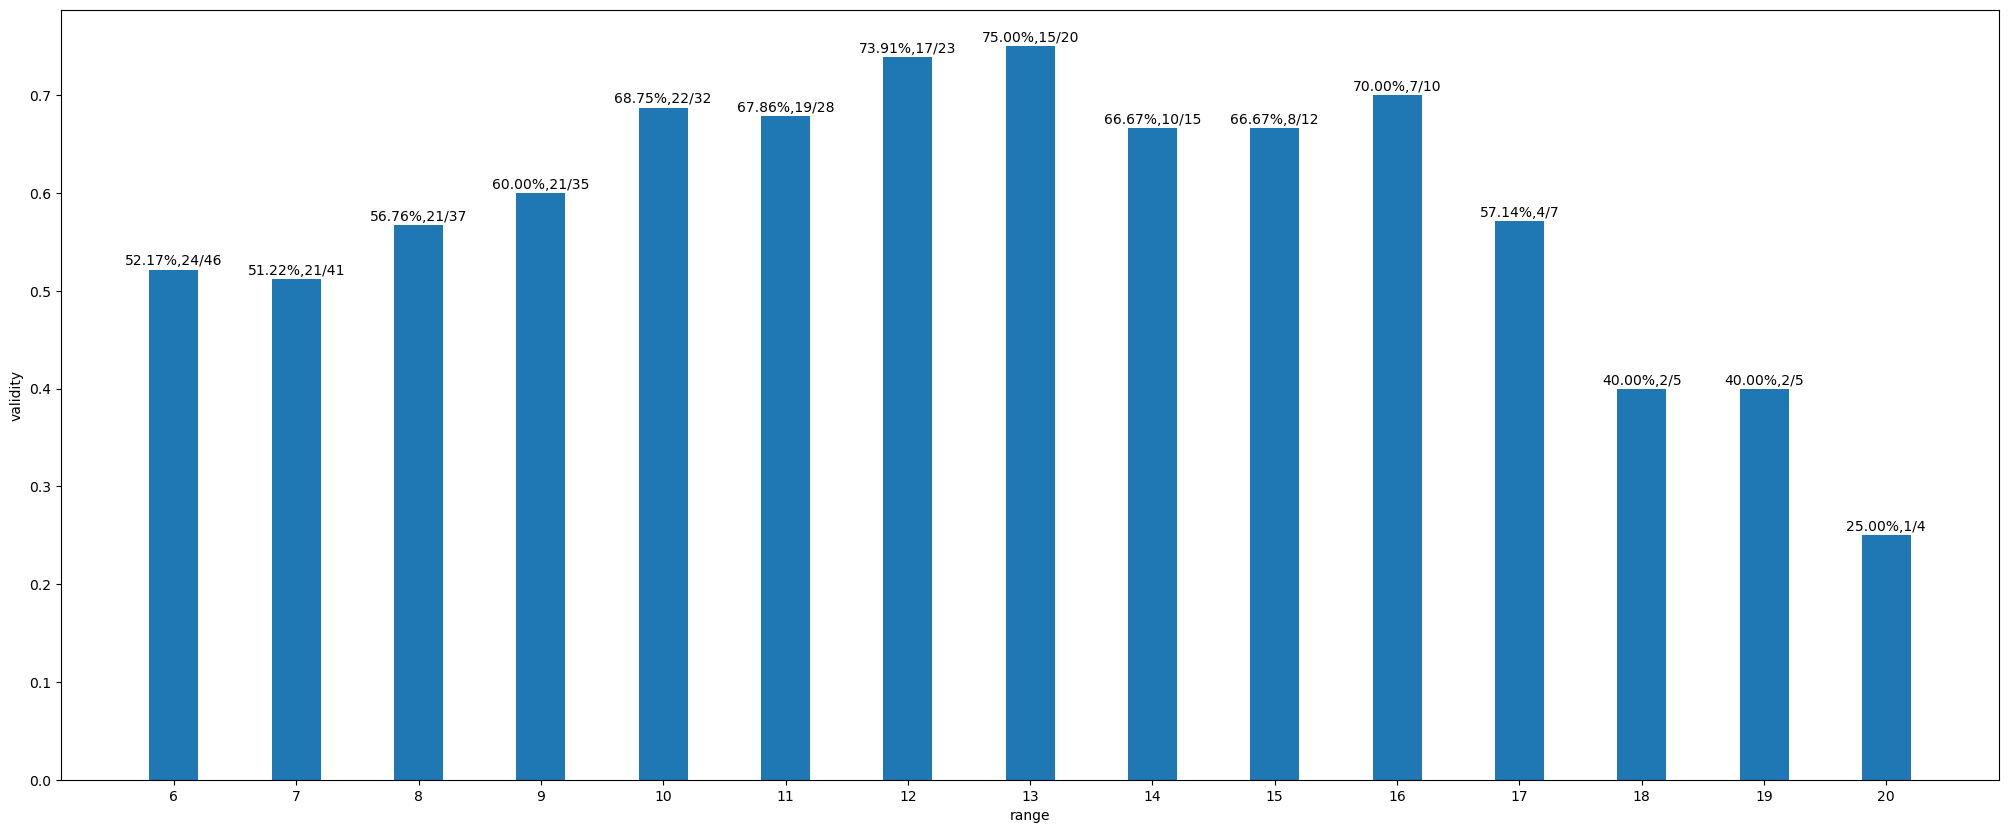

In [30]:
validity, validity_count, reached_count, current_range, (actual_validity, actual_threshold, isEffect), max_index, length = calc(cba, thresholdRange=(6, 20), level=2, q=5,
                                                                                                                                calc_type="增量")
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
ax.set_ylabel('validity')
ax.set_xlabel('range')
width = 0.4  # the width of the bars
labels = list(map(lambda i: f"{i[0]:.2%},{i[1]}/{i[2]}", zip(validity, validity_count, reached_count)))
x_labels = list(map(lambda i: str(i), list(range(6, 21))))
rects1 = ax.bar(x_labels, validity, width)
ax.bar_label(rects1, labels=labels, padding=1)

# plt.show()
plt.savefig("./1.png")